# Mastercard Stock Price Predictions using LSTM

This notebook is inspired by: https://www.kaggle.com/code/thebrownviking20/intro-to-recurrent-neural-networks-lstm-gru

This was my first RNN model. I wanted to put my knowledge of the LSTM into practice and try to forecast the closing price of the stock. I have seen many examples of stock price prediction using this algorithm so I thought this would be an interesting start to the adventure. In practice, the model copies the previous day's value with some residual. It did not turn out to be valuable.


# LSTM 
Long Short-Term Memory (LSTM) is a type of Recurrent Neural Network (RNN) that is specifically designed to handle sequential data, such as time series, speech, and text. LSTM networks are capable of learning long-term dependencies in sequential data, which makes them well suited for tasks such as language translation, speech recognition, and time series forecasting.
Source: https://www.geeksforgeeks.org/deep-learning-introduction-to-long-short-term-memory/

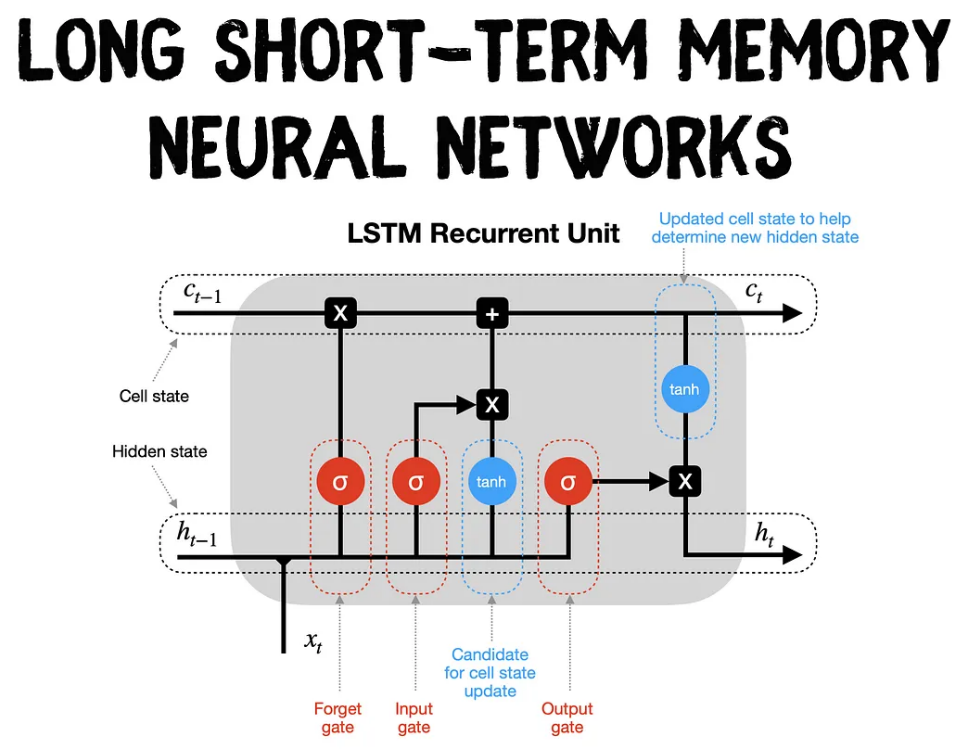
Source: https://towardsdatascience.com/lstm-recurrent-neural-networks-how-to-teach-a-network-to-remember-the-past-55e54c2ff22e

# Imports

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional
from tensorflow.keras import layers, callbacks

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/mastercard-stock-data-latest-and-updated/Mastercard_stock_info.csv
/kaggle/input/mastercard-stock-data-latest-and-updated/Mastercard_stock_history.csv


In [2]:
df = pd.read_csv('/kaggle/input/mastercard-stock-data-latest-and-updated/Mastercard_stock_history.csv')

# Preprocessing

## Dataframe

In [3]:
df.head()

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
0,2006-05-25,3.748967,4.283869,3.739664,4.279217,395343000,0.0,0.0
1,2006-05-26,4.307126,4.348058,4.103398,4.179680,103044000,0.0,0.0
2,2006-05-30,4.183400,4.184330,3.986184,4.093164,49898000,0.0,0.0
3,2006-05-31,4.125723,4.219679,4.125723,4.180608,30002000,0.0,0.0
4,2006-06-01,4.179678,4.474572,4.176887,4.419686,62344000,0.0,0.0


In [4]:
df.tail()

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
3867,2021-10-05,347.121403,348.130138,342.497241,342.776886,4724100,0.00,0.0
3868,2021-10-06,339.580960,348.439763,338.682072,348.250000,3712000,0.00,0.0
3869,2021-10-07,349.000000,357.899994,349.000000,353.910004,3209200,0.44,0.0
3870,2021-10-08,356.000000,360.369995,354.209991,354.959991,2336700,0.00,0.0
3871,2021-10-11,353.950012,354.880005,346.899994,347.149994,2766800,0.00,0.0


## Setting datetime

In [5]:
df.index = pd.to_datetime(df['Date'])
df.drop(columns=['Date'], inplace=True)

## Dividing train and test set

In [6]:
train = df[(df.index.year<2021) & (df.index.year>=2016)]
test = df[df.index.year>=2021]

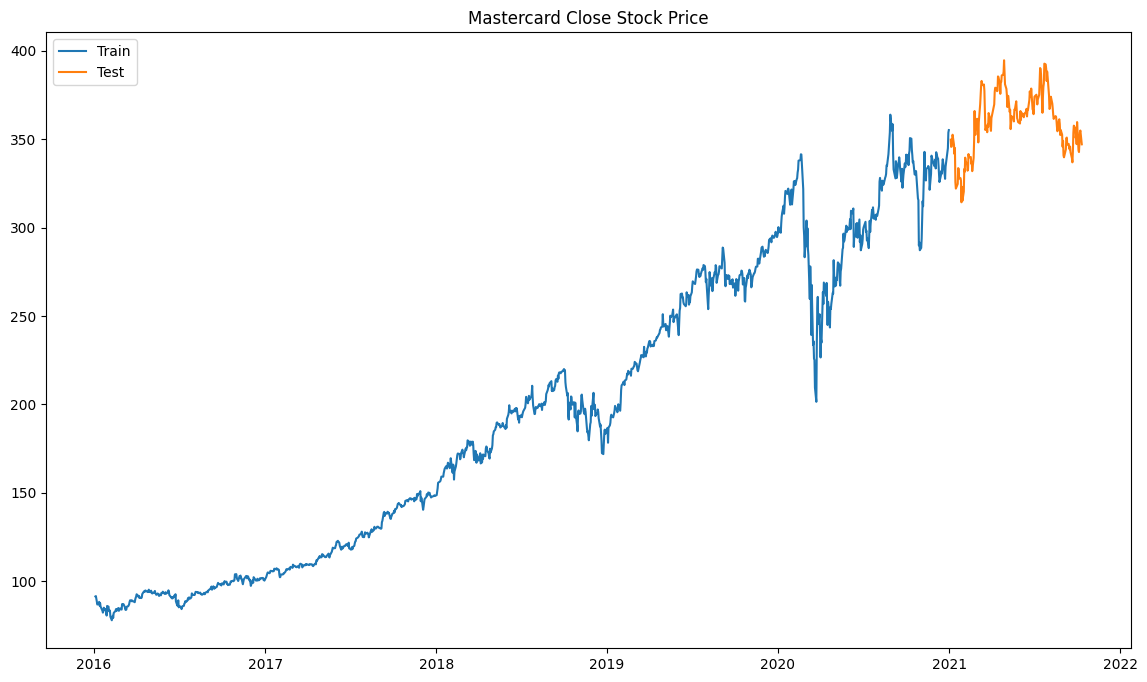

In [7]:
plt.figure(figsize=(14,8))
plt.plot(train['Close'], label='Train')
plt.plot(test['Close'], label='Test')
plt.legend()
plt.title('Mastercard Close Stock Price')
plt.show()

## Feature Scaling
We want to normalize the input data before feeding it to an LSTM model. Normalization helps to scale the data and make it easier for the LSTM to learn. We will translate the featureb between zero and one.

In [8]:
sc = MinMaxScaler(feature_range=(0,1))
training_set_scaled = sc.fit_transform(train['Close'].values.reshape(-1, 1))

In [9]:
X_train = []
y_train = []
for i in range(80,len(training_set_scaled)):
    X_train.append(training_set_scaled[i-80:i,0])
    y_train.append(training_set_scaled[i,0])
X_train, y_train = np.array(X_train), np.array(y_train)

## Reshape
We have to reshape the data before feeding it to an LSTM model

In [10]:
X_train = np.reshape(X_train, (X_train.shape[0],X_train.shape[1],1))

# LSTM Model

In [11]:
model = Sequential([
    LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1],1)),
    layers.Dropout(0.2),
    
    layers.LSTM(units=50, return_sequences=True),
    layers.Dropout(0.2),
    
    layers.LSTM(units=50, return_sequences=True),
    layers.Dropout(0.2),

    layers.LSTM(units=50),
    layers.Dropout(0.2),
    
    layers.Dense(units=1),
])

model.compile(optimizer='adam',loss='mse', metrics=['mse', 'mae', 'mape'])

## Summary

In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 80, 50)            10400     
                                                                 
 dropout (Dropout)           (None, 80, 50)            0         
                                                                 
 lstm_1 (LSTM)               (None, 80, 50)            20200     
                                                                 
 dropout_1 (Dropout)         (None, 80, 50)            0         
                                                                 
 lstm_2 (LSTM)               (None, 80, 50)            20200     
                                                                 
 dropout_2 (Dropout)         (None, 80, 50)            0         
                                                                 
 lstm_3 (LSTM)               (None, 50)                2

## Fitting the model

In [13]:
early_stopping = callbacks.EarlyStopping(
    patience=6,
    min_delta=0.001,
    restore_best_weights=True,
)

history = model.fit(X_train,y_train,epochs=100,batch_size=24, callbacks=[early_stopping])

Epoch 1/100
50/50 [==============================] - 15s 120ms/step - loss: 0.0239 - mse: 0.0239 - mae: 0.1013 - mape: 38.6294
Epoch 2/100
50/50 [==============================] - 6s 121ms/step - loss: 0.0049 - mse: 0.0049 - mae: 0.0464 - mape: 12.3912
Epoch 3/100
50/50 [==============================] - 6s 119ms/step - loss: 0.0053 - mse: 0.0053 - mae: 0.0487 - mape: 13.4548
Epoch 4/100
50/50 [==============================] - 6s 119ms/step - loss: 0.0067 - mse: 0.0067 - mae: 0.0579 - mape: 18.2032
Epoch 5/100
50/50 [==============================] - 6s 123ms/step - loss: 0.0040 - mse: 0.0040 - mae: 0.0419 - mape: 11.0647
Epoch 6/100
50/50 [==============================] - 6s 119ms/step - loss: 0.0043 - mse: 0.0043 - mae: 0.0448 - mape: 12.3979
Epoch 7/100
50/50 [==============================] - 6s 117ms/step - loss: 0.0034 - mse: 0.0034 - mae: 0.0385 - mape: 10.4207
Epoch 8/100
50/50 [==============================] - 6s 122ms/step - loss: 0.0039 - mse: 0.0039 - mae: 0.0410 - mape:

## Validation

Metrics:
* Mean squared error (MSE) - the average squared difference between the predicted values and the actual values.
* Mean absolute error (MAE) - the average absolute difference between the predicted values and the actual values
* Mean absolute percentage error (MAPE) - calculates the percentage difference between the predicted values and the actual values, and then averages these percentage differences

In [14]:
history_frame = pd.DataFrame(history.history)

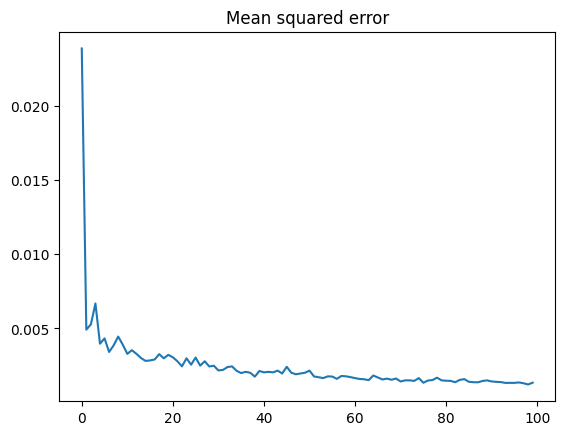

In [15]:
plt.plot(history_frame.loc[:, ['mse']])
plt.title('Mean squared error')
plt.show()

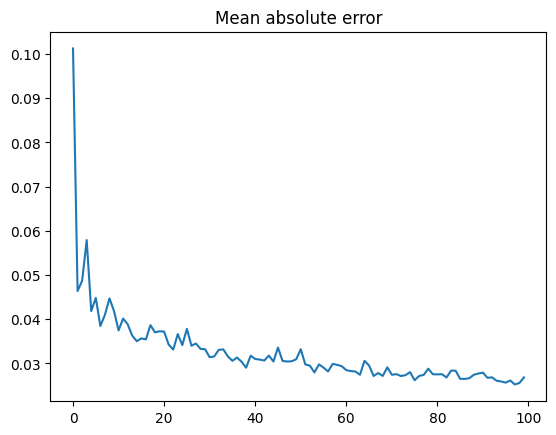

In [16]:
plt.plot(history_frame.loc[:, ['mae']])
plt.title('Mean absolute error')
plt.show()

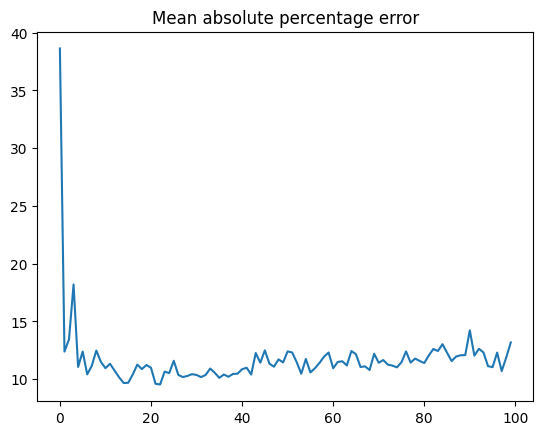

In [17]:
plt.plot(history_frame.loc[:, ['mape']])
plt.title('Mean absolute percentage error')
plt.show()

# Predictions

In [18]:
dataset_total = df['Close']
inputs = dataset_total[len(dataset_total)-len(test['Close'].values) - 80:].values
inputs = inputs.reshape(-1,1)
inputs  = sc.transform(inputs)

In [19]:
X_test = []
for i in range(80,len(inputs)):
    X_test.append(inputs[i-80:i,0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
predicted_stock_price = model.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

7/7 [==============================] - 2s 31ms/step


In [20]:
predictions = pd.DataFrame()
predictions['Actuals'] = test['Close']
predictions['Predictions'] = predicted_stock_price

## Actuals vs Predictions

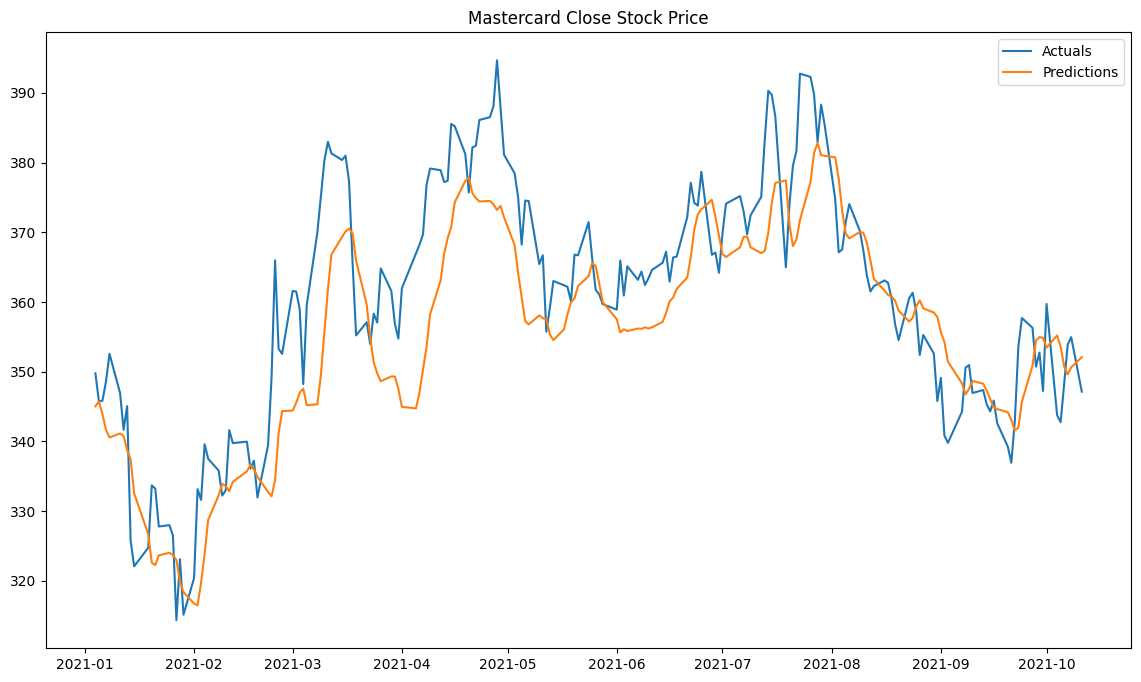

In [21]:
plt.figure(figsize=(14,8))
plt.title('Mastercard Close Stock Price')
plt.plot(predictions['Actuals'], label='Actuals')
plt.plot(predictions['Predictions'], label='Predictions')
plt.legend()
plt.show()